# Chapter - 8 Tree-Based Methods
Five packages are used in the examples of this chapter: ISLR, tree, randomForest, MASS, gbm.

### Regression Trees
The main idea here is to split the predictors' space in such a way that the residual sum of squares (RSS) is minimized. For example let's suppose the response variable Y depends on two predictors $X_1$ and $X_2$. We start with $X_1$ to see which is the value $x_1 = s$ that splits the predictors' space in two boxes $R_1$ and $R_2$ for which some observations fall in $R_1$ and the rest fall in $R_2$ so that  

$$RSS = \sum_{j=1}^J \sum_{x_i \in R_j} (y_i - \hat{y}_{R_j})^2$$

is minimized, and where where $\hat{y}_{R_j}$ is the mean response in the $R_j$ box. The next step is to look for the value $x_2 = s$ that results in the minimum value for RSS. We choose the predictor to split to split depending on which of the two has the lowest RSS. We repeat again the same steps till we reach a stopping criterion such as a minimum number of observations in each box. 

### Classification Trees
The prediction, in case of a categorical predictor, is the most likely category for that predictor. We cannot use RSS to estimate the error in predicting the response for categorical predictors. As an alternative to estimate the error in making binary decisions over a categorical predictor we can use the classification error rate, that is the fraction of observations that do not belong to the most common class in a given box. As an example we consider a bag of marbles with 64 red marbles and 36 blue marbles. We can have a tree with a node "color" so that if a marble taken from the bag is red we follow the branch to the red box and if the marble is blue we follow the branch to the blue box. The classification error rate for the "color" node that we want to minimize is defined as

$$E = 1 - max(\hat p_{red}, \hat p_{blue})$$

where $\hat p_{red}$ is the proportion of red marbles and $\hat p_{blue}$ is the proportion of blue marbles

In [6]:
red_marbles <- 64
blue_marbles <- 36
p_red_box <- red_marbles / (red_marbles + blue_marbles)
p_blue_box <- blue_marbles / (red_marbles + blue_marbles)
error_rate <- 1 - max(p_red_box, p_blue_box)
error_rate

[1] 0.36

Other measures of misclassification are the Gini index

$$G = \sum_{k=1}^K \hat p_{mk} (1 - \hat p_{mk})$$

where in our example m is the node, color, and K = 2 is the number of categories, blue and red.

In [2]:
gini_index <- p_red_box * (1 - p_red_box) + p_blue_box * (1 - p_blue_box)
gini_index

[1] 0.4608

and the cross entropy

$$D = - \sum_{k=1}^K \hat p_{mk} log(\hat p_{mk})$$

In [4]:
cross_entropy <- - (p_red_box * log(p_red_box) + p_blue_box * log(p_blue_box))
cross_entropy

[1] 0.6534182

### 8.3.1 Fitting Classification Trees

In [2]:
library(tree)
library(ISLR)
names(Carseats); dim(Carseats)

[1] "Sales"       "CompPrice"   "Income"      "Advertising" "Population" 
 [6] "Price"       "ShelveLoc"   "Age"         "Education"   "Urban"      
[11] "US"

[1] 400  11

In [3]:
High <- ifelse(Carseats$Sales <= 8, "No", "Yes")
Carseats <- data.frame(Carseats, High)
tree.carseats <- tree(High ~ . - Sales, data = Carseats) # uses all the predictors but Sales
summary(tree.carseats)


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

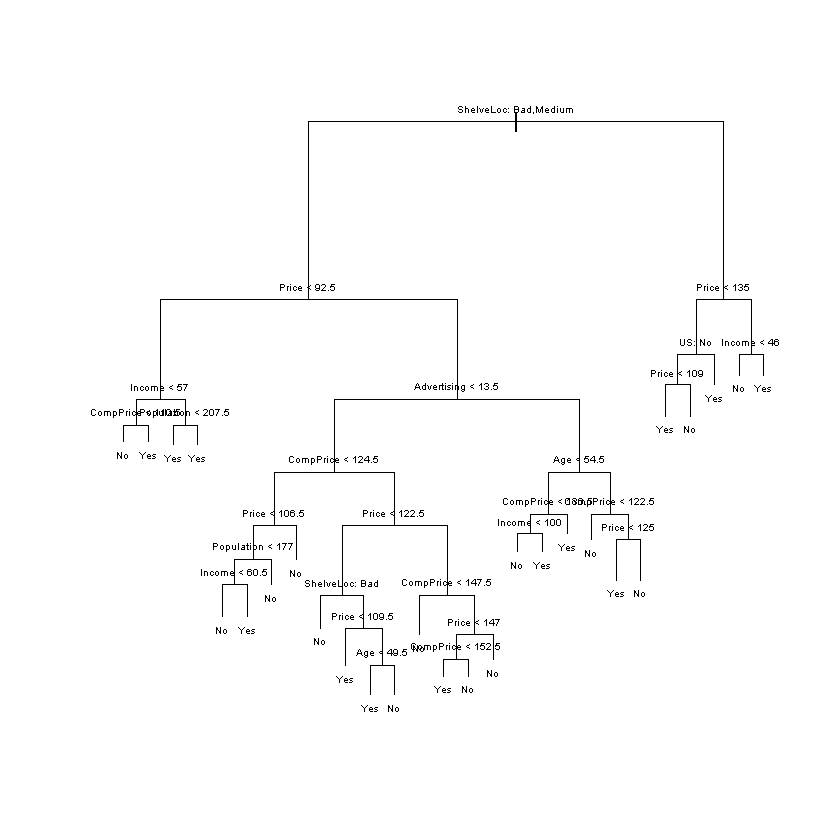

In [9]:
plot(tree.carseats)
text(tree.carseats, pretty = 0, cex= 0.5)

In [13]:
set.seed(2)
train <- sample(1:nrow(Carseats), 200) # random sample of 200 rows from Carseats
Carseats.test <- Carseats[-train, ] # creates the test set removing the train set from the data set
High.test <- High[-train] # same for High field
tree.carseats <- tree(High ~ . - Sales, data = Carseats, subset = train)
tree.pred <- predict(tree.carseats, Carseats.test, type = "class")
table(tree.pred, High.test)

         High.test
tree.pred  No Yes
      No  104  33
      Yes  13  50

In [14]:
(104 + 50) / 200 

[1] 0.77

In [17]:
set.seed(3)
cv.carseats <- cv.tree(tree.carseats, FUN = prune.misclass)
names(cv.carseats)
cv.carseats

[1] "size"   "dev"    "k"      "method"

$size
[1] 21 19 14  9  8  5  3  2  1

$dev
[1] 74 76 81 81 75 77 78 85 81

$k
[1] -Inf  0.0  1.0  1.4  2.0  3.0  4.0  9.0 18.0

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

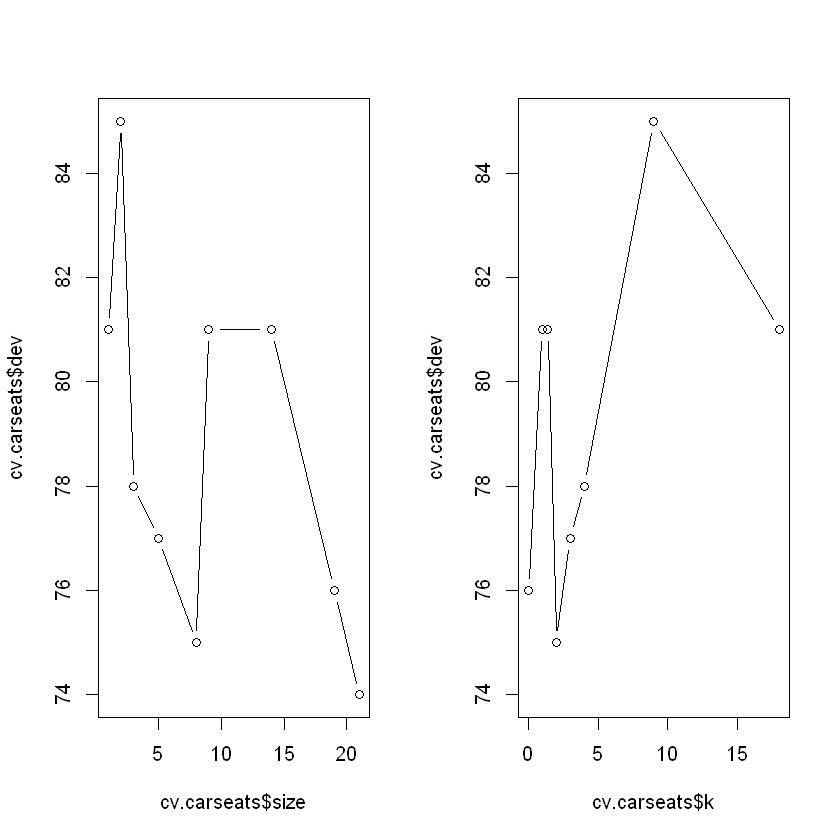

In [19]:
par(mfrow = c(1, 2))
plot(cv.carseats$size, cv.carseats$dev, type = "b")
plot(cv.carseats$k, cv.carseats$dev, type = "b")

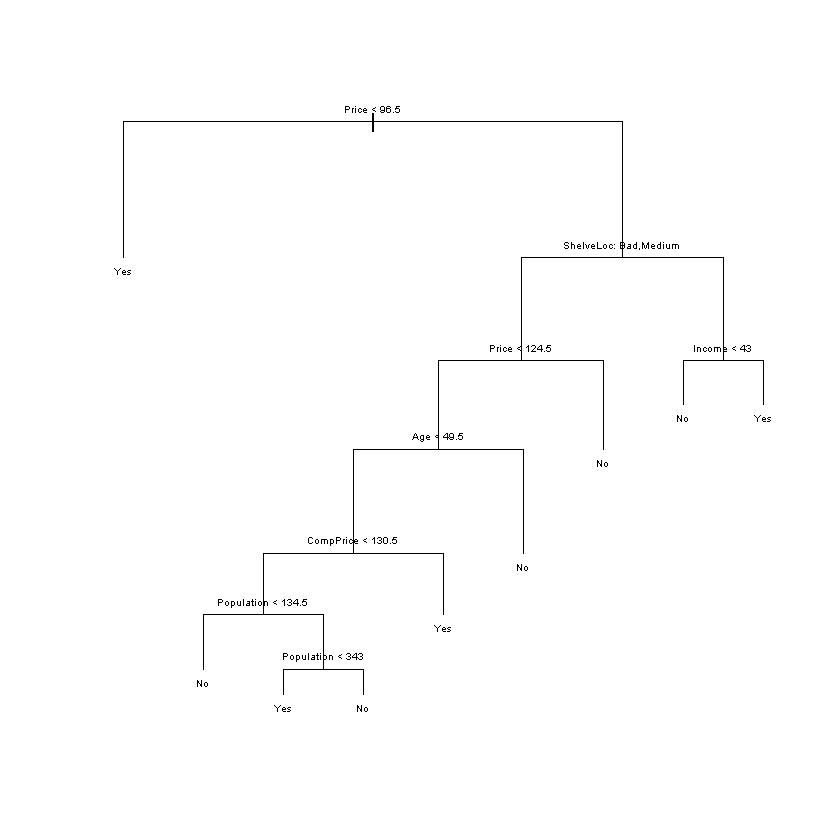

In [24]:
prune.carseats <- prune.misclass(tree.carseats, best = 9)
plot(prune.carseats)
text(prune.carseats, pretty = 0, cex = 0.5)

In [25]:
tree.pred <- predict(prune.carseats, Carseats.test, type = "class")
table(tree.pred, High.test)

         High.test
tree.pred No Yes
      No  97  25
      Yes 20  58

In [26]:
(97 + 58) / 200

[1] 0.775

### 8.3.2 Fitting Regression Tree

In [32]:
library(MASS)
set.seed(1)
train <- sample(1:nrow(Boston), nrow(Boston) / 2)
tree.boston <- tree(medv ~ ., data = Boston, subset = train)
summary(tree.boston)


Regression tree:
tree(formula = medv ~ ., data = Boston, subset = train)
Variables actually used in tree construction:
[1] "rm"    "lstat" "crim"  "age"  
Number of terminal nodes:  7 
Residual mean deviance:  10.38 = 2555 / 246 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-10.1800  -1.7770  -0.1775   0.0000   1.9230  16.5800 

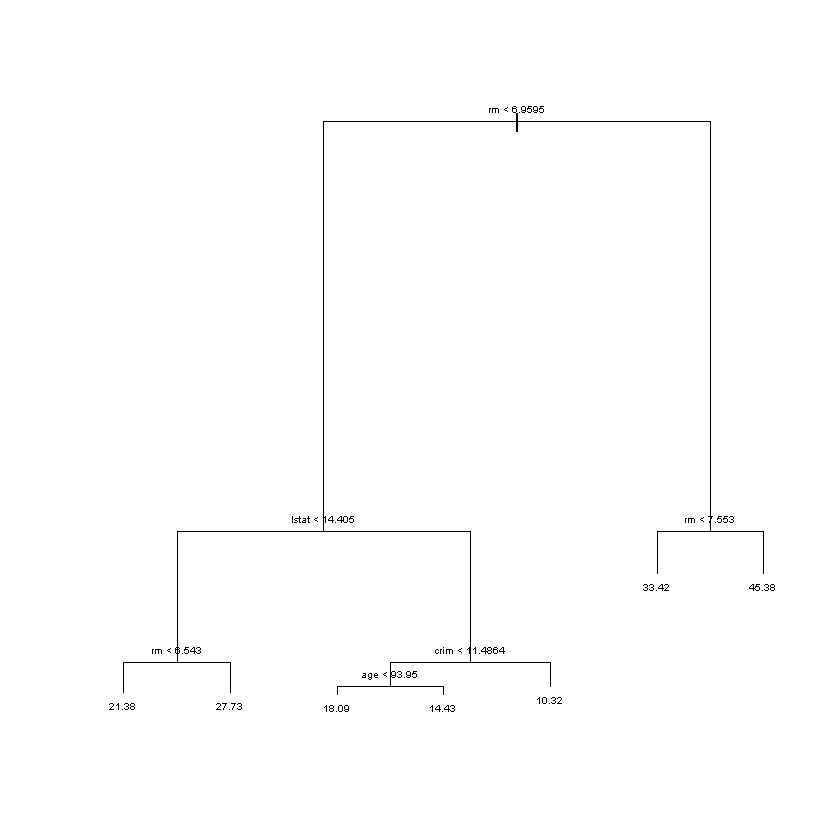

In [33]:
plot(tree.boston)
text(tree.boston, pretty = 0, cex = 0.5)

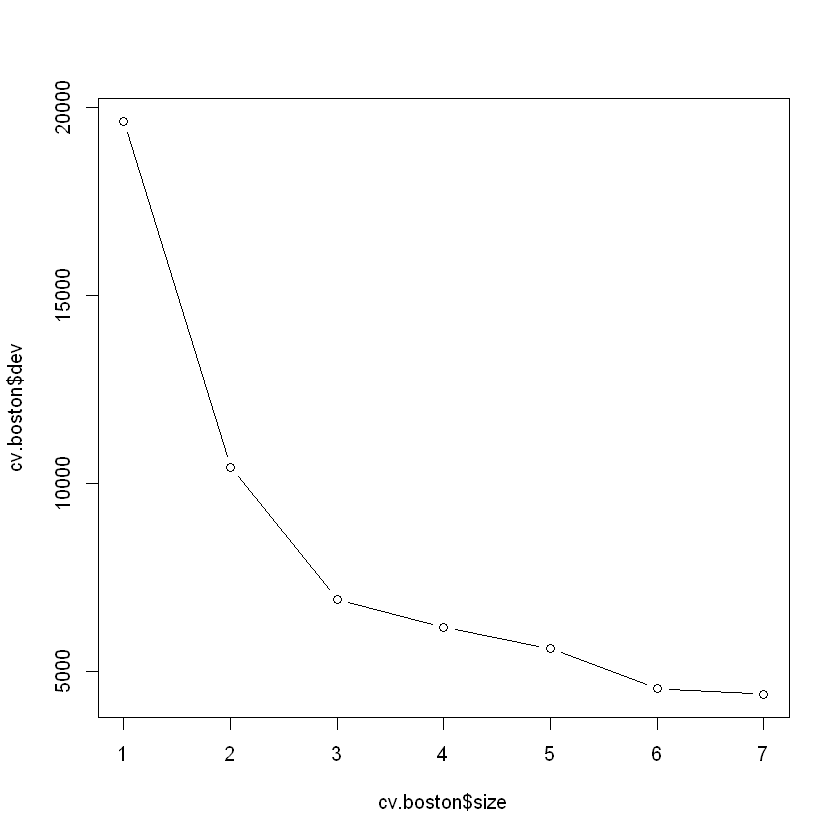

In [34]:
cv.boston <- cv.tree(tree.boston)
plot(cv.boston$size, cv.boston$dev, type = "b")

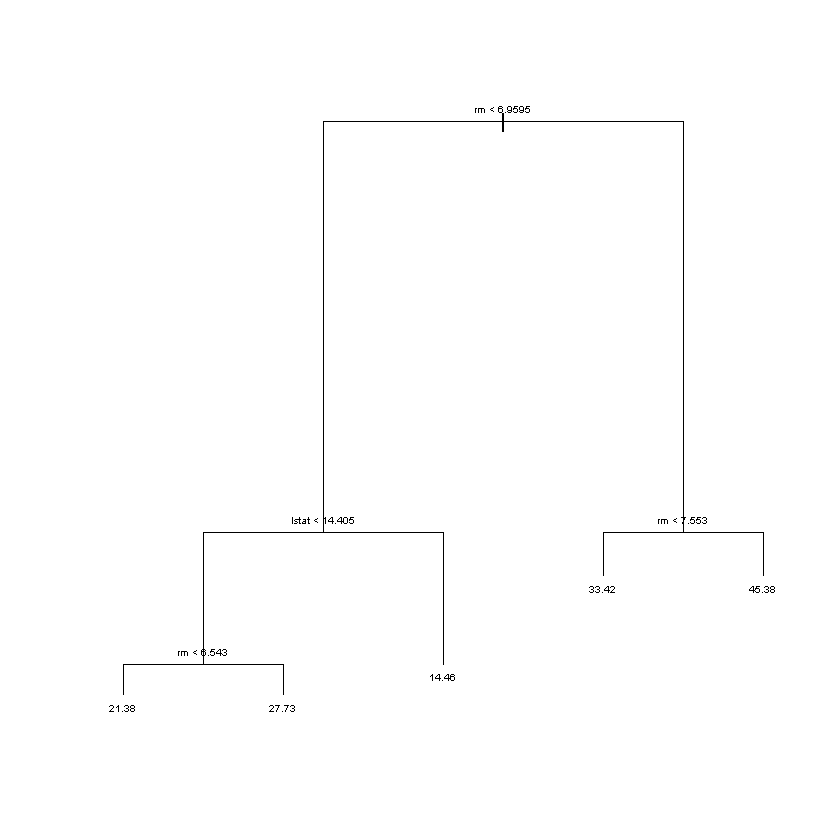

In [35]:
prune.boston <- prune.tree(tree.boston, best = 5)
plot(prune.boston)
text(prune.boston, pretty = 0, cex = 0.5)

[1] 35.28688

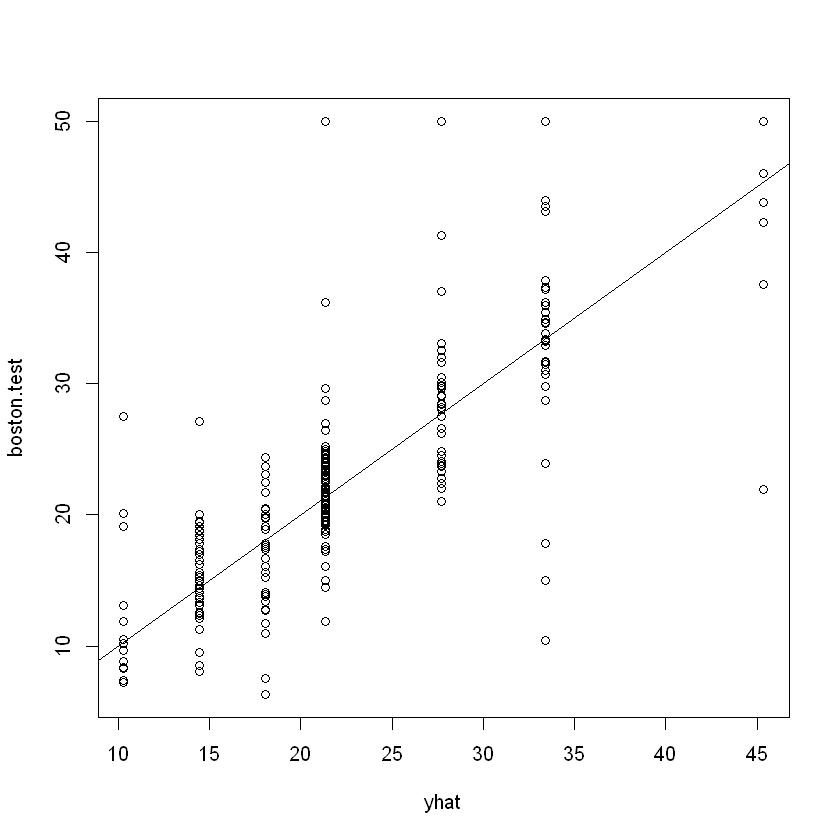

In [36]:
yhat <- predict(tree.boston, newdata = Boston[-train, ])
boston.test <- Boston[-train, "medv"]
plot(yhat, boston.test)
abline(0, 1)
mean((yhat - boston.test)^2)